# Notebook de exploração da biblioteca GDAL

Pela alta complexidade das imagens de satélites elas são salvas em formatos meio complexos, como .tiff, o que dificulta nosso trabalho com elas. 

GDAL (Geospatial Data Abstraction Library) é uma biblioteca que rasteriza e vetoriza imagens de satélite, assim conseguimos aplicar os processos que precisamos. Ela também está disponivel para C e C++.

## Instalação

A instalação por pip não me parece funcionar muito bem, mas se alguém quiser tentar é:
```
pip install GDAL
```
O método padrão parece ser instalar utilizando a wheel da biblioteca.
* Acesse https://www.lfd.uci.edu/~gohlke/pythonlibs/#gdal e baixe a wheel correspondente a sua versão de python
* Instale a wheel com o seguinte comando: ```python -m pip install path_to_gdal ```

**Side Note**: Se você tem o QGIS o GDAL vem instalado no python embarcado no programa

## Utilização

In [29]:
import gdal
import numpy as np
import matplotlib.pyplot as plt

Abrindo um arquivo e printando informações básicas sobre ele

In [2]:
filename = 'img_teste2.tif'
dataset = gdal.Open(filename, gdal.GA_ReadOnly)

print("Driver: {}/{}".format(dataset.GetDriver().ShortName,
                            dataset.GetDriver().LongName))
print("Size is {} x {} x {}".format(dataset.RasterXSize,
                                    dataset.RasterYSize,
                                    dataset.RasterCount))
print("Projection is {}".format(dataset.GetProjection()))
geotransform = dataset.GetGeoTransform()
if geotransform:
    print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
    print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))

Driver: GTiff/GeoTIFF
Size is 515 x 305 x 3
Projection is PROJCS["WGS 84 / UTM zone 19S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-69],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32719"]]
Origin = (352860.0, 8159660.0)
Pixel Size = (10.0, -10.0)


In [6]:
band0 = dataset.GetRasterBand(1)
print(f'No data value: {band0.GetNoDataValue()}')
print(f'Minimum: {band0.GetMinimum()}')
print(f'Minimum: {band0.GetMaximum()}')
print(f'Data type: {band0.GetUnitType()}')

No data value: None
Minimum: None
Minimum: None
Data type: 


In [3]:
print(f'Number of raster bands: {dataset.RasterCount}')

Number of raster bands: 3


### Imprimindo uma Raster Band

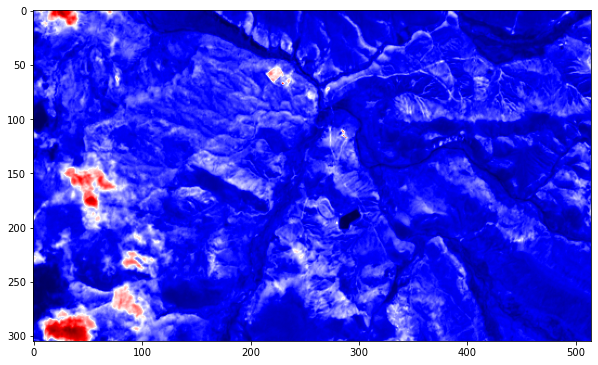

In [77]:
band1 = dataset.GetRasterBand(1).ReadAsArray()
plt.figure(figsize = (10,10))
plt.imshow(band1,cmap='seismic')
plt.show()

### Fazendo operações com Raster Bands

In [67]:
def openRaster(filename, acess=0):
    dataset = gdal.Open(filename, acess)
    if dataset is None:
        print("Erro ao abrir o arquivo")
    return dataset

def getRasterBand(filename, band=1, acess=0):
    dataset = openRaster(filename,acess)
    raster_band = dataset.GetRasterBand(band).ReadAsArray()
    return raster_band

def createRasterFromCopy(filename,dataset, data, driveFmt='GTiff'):
    driver = gdal.GetDriverbyName(driverFmt)
    out_dataset = driver.CreateCopy(filename, dataset, strict=0)
    out_dataset.getRasterBand(1).WriteArray(data)
    dataset = None
    out_dataset = None
    
def createRasterFromTemplate(filename, dataset, data, ndv=-9999.0, driverFmt='GTiff'):
    driver = gdal.GetDriverByName(driverFmt)
    out_dataset = driver.Create(filename, xsize=dataset.RasterXSize, ysize=dataset.RasterYSize,
                                bands=1, eType = gdal.GDT_Float32)
    out_dataset.SetGeoTransform(dataset.GetGeoTransform())
    out_dataset.SetProjection(dataset.GetProjection())
    #out_dataset.GetRasterBand(1).SetNoDataValue(ndv)
    out_dataset.GetRasterBand(1).WriteArray(data)
    dataset = None
    out_dataset = None
    
def indice_estevam(band1, band2, ndv=-9999.0):
    #band1[band1 < 0] = np.nan
    #band1[band1 < 10000] = np.nan
    #band2[band2 < 0] = np.nan
    #band2[band2 < 10000] = np.nan
    estavam_band = (band1-band2)/(band1+band2)
    return estavam_band
    '''
    Para o NDVI isso se pareceria com:
def ndvi(nirband, redband):
    estavam_band = (nirband-redband)/(nirband+redband)
    return estavam_band
    '''

In [73]:
filename = 'img_teste2.tif'
out_filename = 'estevam.tif'

band1 = getRasterBand(filename, 1)
band2 = getRasterBand(filename, 2)
estevam_band = indice_estevam(band1,band2)
createRasterFromTemplate(out_filename, gdal.Open(filename), estevam_band)

In [75]:
filename = 'estevam.tif'
band1 = getRasterBand(filename, 1)


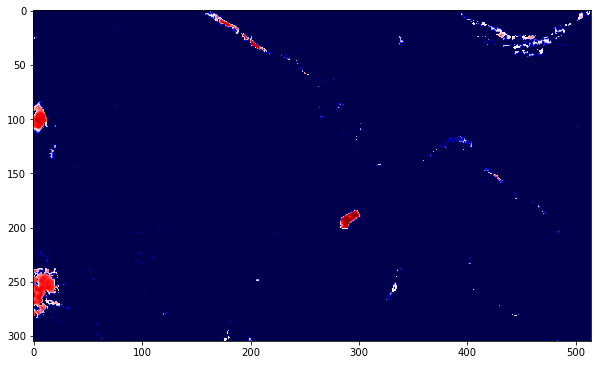

In [76]:
plt.figure(figsize = (10,10))
plt.imshow(band1,cmap='seismic')
plt.show()